In [1]:
import pandas as pd
from matplotlib import figure
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
# Setup data frame.
df = pd.read_csv('MA_Public_Schools_2017.csv')

In [2]:
#Intial viewing of data setup and information
print(df.shape)
df.head()


(1861, 302)


,School Code,School Name,School Type,Function,Contact Name,Address 1,Address 2,Town,State,Zip,...,MCAS_10thGrade_English_Incl. in SGP(#),Accountability and Assistance Level,Accountability and Assistance Description,School Accountability Percentile (1-99),Progress and Performance Index (PPI) - All Students,Progress and Performance Index (PPI) - High Needs Students,District_Accountability and Assistance Level,District_Accountability and Assistance Description,District_Progress and Performance Index (PPI) - All Students,District_Progress and Performance Index (PPI) - High Needs Students
0,10505,Abington High,Public School,Principal,Teresa Sullivan-Cruz,201 Gliniewicz Way,NaN,Abington,MA,2351,...,111.0,Level 1,Meeting gap narrowing goals,42.0,76.0,75.0,Level 3,One or more schools in the district classified...,63.0,60.0
1,10003,Beaver Brook Elementary School,Public School,Principal,Catherine Zinni,1 Ralph Hamlin Lane,NaN,Abington,MA,2351,...,NaN,Level 3,Among lowest performing 20% of subgroups,34.0,69.0,73.0,Level 3,One or more schools in the district classified...,63.0,60.0
2,10002,Center Elementary School,Public School,Principal,Lora Monachino,201 Gliniewicz Way,NaN,Abington,MA,2351,...,NaN,Insufficient data,NaN,NaN,NaN,NaN,Level 3,One or more schools in the district classified...,63.0,60.0
3,10405,Frolio Middle School,Public School,Principal,Matthew MacCurtain,201 Gliniewicz Way,NaN,Abington,MA,2351,...,NaN,Level 2,Not meeting gap narrowing goals,40.0,63.0,64.0,Level 3,One or more schools in the district classified...,63.0,60.0
4,10015,Woodsdale Elementary School,Public School,Principal,Jonathan Hawes,128 Chestnut Street,NaN,Abington,MA,2351,...,NaN,Level 2,Not meeting gap narrowing goals,52.0,65.0,67.0,Level 3,One or more schools in the district classified...,63.0,60.0


In [3]:
# Using drop() to delete rows based on schools that do not support up to 12th grade. The goal of this project is to explore
# SAT performance so we are going remove schools who do have SAT data to report.
df= df.dropna(subset=['Average SAT_Reading'])
df.shape

(332, 302)

<h1> Features to cut </h1>
<p> I am going to cut many features based on the the control a school could have over these values and some domain knoweldge on the topic. More or less they fit into two groups. One group is just descrivtive info about the school or building such as  fax number that truly should have no impact on the performance of the students. The other is based on measurements for lower grades. We are focusing on students who have SAT scores. This means while some schools could bave k-12 a typical school in the USA is either k-5, 6-8, or 9-12. With 9-12 being the students who gernally take the SAT. </p>
<br>


In [4]:
droplist = ['School Name','Function','Contact Name','Address 1','Address 2','Town','State','Phone','Fax','Grade',
            'PK_Enrollment','1_Enrollment','2_Enrollment','3_Enrollment','4_Enrollment','5_Enrollment','6_Enrollment',
            '7_Enrollment','8_Enrollment','District Name', 'District Code', 'K_Enrollment','MCAS_3rdGrade_Math_P+A #', 
            '% MCAS_3rdGrade_Math_P+A', 'MCAS_3rdGrade_Math_A #', '% MCAS_3rdGrade_Math_A', 'MCAS_3rdGrade_Math_P #', 
            '% MCAS_3rdGrade_Math_P', 'MCAS_3rdGrade_Math_NI #', '% MCAS_3rdGrade_Math_NI', 'MCAS_3rdGrade_Math_W/F #', 
            '% MCAS_3rdGrade_Math_W/F', 'MCAS_3rdGrade_Math_Stud. Incl. #', 'MCAS_3rdGrade_Math_CPI', 'MCAS_3rdGrade_Math_SGP',
            'MCAS_3rdGrade_Math_Incl. in SGP(#)', 'MCAS_4thGrade_Math_P+A #', '% MCAS_4thGrade_Math_P+A', 
            'MCAS_4thGrade_Math_A #', '% MCAS_4thGrade_Math_A', 'MCAS_4thGrade_Math_P #', '% MCAS_4thGrade_Math_P', 
            'MCAS_4thGrade_Math_NI #', '% MCAS_4thGrade_Math_NI', 'MCAS_4thGrade_Math_W/F #', '% MCAS_4thGrade_Math_W/F', 
            'MCAS_4thGrade_Math_Stud. Incl. #', 'MCAS_4thGrade_Math_CPI', 'MCAS_4thGrade_Math_SGP', 
            'MCAS_4thGrade_Math_Incl. in SGP(#)', 'MCAS_5thGrade_Math_P+A #', '% MCAS_5thGrade_Math_P+A', 
            'MCAS_5thGrade_Math_A #', '% MCAS_5thGrade_Math_A', 'MCAS_5thGrade_Math_P #', '% MCAS_5thGrade_Math_P', 
            'MCAS_5thGrade_Math_NI #', '% MCAS_5thGrade_Math_NI', 'MCAS_5thGrade_Math_W/F #', '% MCAS_5thGrade_Math_W/F', 
            'MCAS_5thGrade_Math_Stud. Incl. #', 'MCAS_5thGrade_Math_CPI', 'MCAS_5thGrade_Math_SGP', 
            'MCAS_5thGrade_Math_Incl. in SGP(#)', 'MCAS_6thGrade_Math_P+A #', '% MCAS_6thGrade_Math_P+A', 
            'MCAS_6thGrade_Math_A #', '% MCAS_6thGrade_Math_A', 'MCAS_6thGrade_Math_P #', '% MCAS_6thGrade_Math_P', 
            'MCAS_6thGrade_Math_NI #', '% MCAS_6thGrade_Math_NI', 'MCAS_6thGrade_Math_W/F #', '% MCAS_6thGrade_Math_W/F', 
            'MCAS_6thGrade_Math_Stud. Incl. #', 'MCAS_6thGrade_Math_CPI', 'MCAS_6thGrade_Math_SGP', 
            'MCAS_6thGrade_Math_Incl. in SGP(#)', 'MCAS_7thGrade_Math_P+A #', '% MCAS_7thGrade_Math_P+A', 
            'MCAS_7thGrade_Math_A #', '% MCAS_7thGrade_Math_A', 'MCAS_7thGrade_Math_P #', '% MCAS_7thGrade_Math_P', 
            'MCAS_7thGrade_Math_NI #', '% MCAS_7thGrade_Math_NI', 'MCAS_7thGrade_Math_W/F #', '% MCAS_7thGrade_Math_W/F', 
            'MCAS_7thGrade_Math_Stud. Incl. #', 'MCAS_7thGrade_Math_CPI', 'MCAS_7thGrade_Math_SGP',
            'MCAS_7thGrade_Math_Incl. in SGP(#)', 'MCAS_8thGrade_Math_P+A #', '% MCAS_8thGrade_Math_P+A', 
            'MCAS_8thGrade_Math_A #', '% MCAS_8thGrade_Math_A', 'MCAS_8thGrade_Math_P #', '% MCAS_8thGrade_Math_P',
            'MCAS_8thGrade_Math_NI #', '% MCAS_8thGrade_Math_NI', 'MCAS_8thGrade_Math_W/F #', 
            '% MCAS_8thGrade_Math_W/F', 'MCAS_8thGrade_Math_Stud. Incl. #', 'MCAS_8thGrade_Math_CPI',
            'MCAS_8thGrade_Math_SGP', 'MCAS_8thGrade_Math_Incl. in SGP(#)','MCAS_3rdGrade_English_P+A #',
            '% MCAS_3rdGrade_English_P+A', 'MCAS_3rdGrade_English_A #', '% MCAS_3rdGrade_English_A', 
            'MCAS_3rdGrade_English_P #', '% MCAS_3rdGrade_English_P', 'MCAS_3rdGrade_English_NI #', 
            '% MCAS_3rdGrade_English_NI', 'MCAS_3rdGrade_English_W/F #', '% MCAS_3rdGrade_English_W/F', 
            'MCAS_3rdGrade_English_Stud. Incl. #', 'MCAS_3rdGrade_English_CPI', 'MCAS_3rdGrade_English_SGP',
            'MCAS_3rdGrade_English_Incl. in SGP(#)', 'MCAS_4thGrade_English_P+A #', 
            '% MCAS_4thGrade_English_P+A', 'MCAS_4thGrade_English_A #', '% MCAS_4thGrade_English_A',
            'MCAS_4thGrade_English_P #', '% MCAS_4thGrade_English_P', 'MCAS_4thGrade_English_NI #', 
            '% MCAS_4thGrade_English_NI', 'MCAS_4thGrade_English_W/F #', '% MCAS_4thGrade_English_W/F',
            'MCAS_4thGrade_English_Stud. Incl. #', 'MCAS_4thGrade_English_CPI', 'MCAS_4thGrade_English_SGP', 
            'MCAS_4thGrade_English_Incl. in SGP(#)', 'MCAS_5thGrade_English_P+A #', '% MCAS_5thGrade_English_P+A',
            'MCAS_5thGrade_English_A #', '% MCAS_5thGrade_English_A', 'MCAS_5thGrade_English_P #',
            '% MCAS_5thGrade_English_P', 'MCAS_5thGrade_English_NI #', '% MCAS_5thGrade_English_NI', 
            'MCAS_5thGrade_English_W/F #', '% MCAS_5thGrade_English_W/F',
            'MCAS_5thGrade_English_Stud. Incl. #', 'MCAS_5thGrade_English_CPI', 'MCAS_5thGrade_English_SGP', 
            'MCAS_5thGrade_English_Incl. in SGP(#)', 'MCAS_6thGrade_English_P+A #',
            '% MCAS_6thGrade_English_P+A', 'MCAS_6thGrade_English_A #', '% MCAS_6thGrade_English_A',
            'MCAS_6thGrade_English_P #', '% MCAS_6thGrade_English_P', 'MCAS_6thGrade_English_NI #', 
            '% MCAS_6thGrade_English_NI', 'MCAS_6thGrade_English_W/F #', '% MCAS_6thGrade_English_W/F',
            'MCAS_6thGrade_English_Stud. Incl. #', 'MCAS_6thGrade_English_CPI', 'MCAS_6thGrade_English_SGP', 
            'MCAS_6thGrade_English_Incl. in SGP(#)', 'MCAS_7thGrade_English_P+A #', '% MCAS_7thGrade_English_P+A',
            'MCAS_7thGrade_English_A #', '% MCAS_7thGrade_English_A', 'MCAS_7thGrade_English_P #',
            '% MCAS_7thGrade_English_P', 'MCAS_7thGrade_English_NI #', '% MCAS_7thGrade_English_NI', 
            'MCAS_7thGrade_English_W/F #', '% MCAS_7thGrade_English_W/F',
            'MCAS_7thGrade_English_Stud. Incl. #', 'MCAS_7thGrade_English_CPI', 
            'MCAS_7thGrade_English_SGP', 'MCAS_7thGrade_English_Incl. in SGP(#)',
            'MCAS_8thGrade_English_P+A #', '% MCAS_8thGrade_English_P+A', 'MCAS_8thGrade_English_A #', 
            '% MCAS_8thGrade_English_A', 'MCAS_8thGrade_English_P #', '% MCAS_8thGrade_English_P',
            'MCAS_8thGrade_English_NI #', '% MCAS_8thGrade_English_NI', 'MCAS_8thGrade_English_W/F #', 
            '% MCAS_8thGrade_English_W/F', 'MCAS_8thGrade_English_Stud. Incl. #', 'MCAS_8thGrade_English_CPI',
            'MCAS_8thGrade_English_SGP', 'MCAS_8thGrade_English_Incl. in SGP(#)',
            '% MCAS_10thGrade_Math_A', 'MCAS_10thGrade_Math_CPI','% MCAS_10thGrade_English_A', '% MCAS_10thGrade_English_P',
            '% MA Community College','% MA State University', '% Private Four-Year', '% Public Two-Year',
            '% MCAS_10thGrade_Math_P+A','% MCAS_10thGrade_Math_NI']

In [5]:
df = df.drop(droplist, axis=1)

In [6]:
#Clean Columns I am going to manually review the types of the objects and autmatically fill in the NA values based on their type.
cols = df.columns
for column in cols:
    print(column , df[column].dtype)
for column in cols:
    datatype = df[column].dtype
    if datatype == 'int64':
        mean = df[column].mean()
        df[column]=df[column].fillna(mean)
    elif datatype =='float64':
        mean = df[column].mean()
        df[column]=df[column].fillna(mean)
    else:
        mode = df[column].mode()
        df[column]=df[column].fillna(mode)

School Code int64
School Type object
Zip int64
9_Enrollment int64
10_Enrollment int64
11_Enrollment int64
12_Enrollment int64
SP_Enrollment int64
TOTAL_Enrollment int64
First Language Not English float64
% First Language Not English float64
English Language Learner float64
% English Language Learner float64
Students With Disabilities float64
% Students With Disabilities float64
High Needs float64
% High Needs float64
Economically Disadvantaged float64
% Economically Disadvantaged float64
% African American float64
% Asian float64
% Hispanic float64
% White float64
% Native American float64
% Native Hawaiian, Pacific Islander float64
% Multi-Race, Non-Hispanic float64
% Males float64
% Females float64
Total # of Classes float64
Average Class Size float64
Number of Students float64
Salary Totals float64
Average Salary float64
FTE Count float64
In-District Expenditures float64
Total In-district FTEs float64
Average In-District Expenditures per Pupil float64
Total Expenditures float64
Tota

In [7]:
#Upon review we can see the AP_Test Takers and AP_Tests Taken are listed as objects. A quick view of the columns shows
#they should be numerical values so I am going to convert the strings in the columns and replace na again to see if this handels
#the cleaning needed.

df['AP_Test Takers']=df['AP_Test Takers'].str.replace(',','')
df['AP_Test Takers'] = df['AP_Test Takers'].apply(lambda x: float(x))

df['AP_Tests Taken']=df['AP_Tests Taken'].str.replace(',','')
df['AP_Tests Taken'] = df['AP_Tests Taken'].apply(lambda x: float(x))

In [8]:
# I ran this batch of code again after cleaning the two columns to ensure we hadled any na values.
cols = df.columns
for column in cols:
    print(column , df[column].dtype)
for column in cols:
    datatype = df[column].dtype
    if datatype == 'int64':
        mean = df[column].mean()
        df[column]=df[column].fillna(mean)
    elif datatype =='float64':
        mean = df[column].mean()
        df[column]=df[column].fillna(mean)
    else:
        mode = df[column].mode()
        df[column]=df[column].fillna(mode)

School Code int64
School Type object
Zip int64
9_Enrollment int64
10_Enrollment int64
11_Enrollment int64
12_Enrollment int64
SP_Enrollment int64
TOTAL_Enrollment int64
First Language Not English float64
% First Language Not English float64
English Language Learner float64
% English Language Learner float64
Students With Disabilities float64
% Students With Disabilities float64
High Needs float64
% High Needs float64
Economically Disadvantaged float64
% Economically Disadvantaged float64
% African American float64
% Asian float64
% Hispanic float64
% White float64
% Native American float64
% Native Hawaiian, Pacific Islander float64
% Multi-Race, Non-Hispanic float64
% Males float64
% Females float64
Total # of Classes float64
Average Class Size float64
Number of Students float64
Salary Totals float64
Average Salary float64
FTE Count float64
In-District Expenditures float64
Total In-district FTEs float64
Average In-District Expenditures per Pupil float64
Total Expenditures float64
Tota

In [9]:
#make dummies to keep track of catergorical values.

dummylist = []
for column in cols:
    datatype = df[column].dtype
    if datatype == object:
        dummylist.append(column)

df_dummies = pd.get_dummies(df, prefix='', prefix_sep='', columns=dummylist)
df_dummies.head()

,School Code,Zip,9_Enrollment,10_Enrollment,11_Enrollment,12_Enrollment,SP_Enrollment,TOTAL_Enrollment,First Language Not English,% First Language Not English,...,Low assessment participation (Less than 95%),Meeting gap narrowing goals,Not meeting gap narrowing goals,One or more schools in the district classified into Level 1,One or more schools in the district classified into Level 2,One or more schools in the district classified into Level 3,One or more schools in the district classified into Level 4,Persistently low graduation rate for one or more groups,Underperforming district,Very low assessment participation (Less than 90%)
0,10505,2351,124,109,123,92,4,452,24.0,5.3,...,0,0,0,0,0,1,0,0,0,0
8,50505,1001,299,309,293,315,6,1222,56.0,4.6,...,0,0,0,0,1,0,0,0,0,0
16,70505,1913,147,138,145,163,1,594,17.0,2.9,...,0,0,0,0,1,0,0,0,0,0
23,90505,1810,446,459,421,462,18,1806,172.0,9.5,...,0,0,0,0,1,0,0,0,0,0
33,100505,2476,332,350,312,295,1,1290,160.0,12.4,...,0,0,0,0,1,0,0,0,0,0


In [10]:
# I am going to split the data between the targets and features.
droplist3=["Average SAT_Writing",'Average SAT_Math','Average SAT_Reading']
Y= df[["Average SAT_Writing",'Average SAT_Math','Average SAT_Reading']]
X = df_dummies.drop(columns=droplist3)


In [11]:
#A 2/3 split to create the testing and training groups based on the list created prior.
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.33, random_state=42)

In [19]:
# Scaled the data to make the computation more efficient. 
sc = StandardScaler()
X_train_norm = sc.fit_transform(X_train)
X_test_norm = sc.transform(X_test)

In [23]:
# define the method for Recursive Feature Elimination. The goal is to choose 10 features that best represent the more important featues.
# from there we can create a model and interpret more deeply the meaning of the features.
rfe = RFE(estimator=RandomForestRegressor(n_estimators = 100), n_features_to_select=10)
# fit the model
rfe.fit(X_train, y_train)


RFE(estimator=RandomForestRegressor(), n_features_to_select=10)

In [24]:
# Fetching the Original Columns the RFE reported back. I am calling from before the transform since the locations will
# remian intact but the scalling converts the data to numpy and does not carry the .loc function.
FeatureNames = X_train.loc[:, rfe.support_].columns
print(FeatureNames)

Index(['% High Needs', '% Economically Disadvantaged', '% White',
       'Average Class Size', '% Attending College', 'AP_Score=5',
       '% AP_Score 1-2', '% AP_Score 3-5', '% MCAS_10thGrade_Math_P',
       'School Accountability Percentile (1-99)'],
      dtype='object')


In [30]:
#Applying the results of the recursive feature elimination to crete sets for the model creation.
XFinalTrain = rfe.transform(X_train)
XFinalTest =rfe.transform(X_test)

In [26]:
# I used RFE to recude issues with multicolinearity in the data and help optimize the model creation. This made the choice of 
# a linear regression feel more appropraite than other more methods for my first model creation. 
regr = LinearRegression()


regr.fit(XFinalTrain, y_train)
predictions = regr.predict(XFinalTest)

In [36]:
XFinalTrain.shape

(222, 10)

In [37]:
#An array of the coefficents for each feature for each target.
regr.coef_[0]

array([-8.89347269e-01, -1.20841653e-01,  5.92285023e-01, -7.23258056e-01,
        1.09914569e+00,  1.45766389e-01, -2.92994167e+02, -2.92839879e+02,
       -8.29954313e-01,  1.25976038e-01])

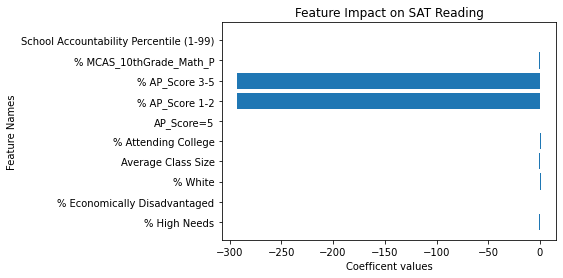

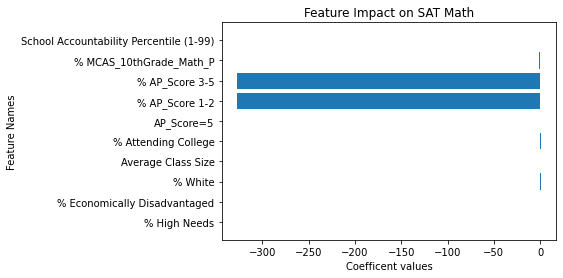

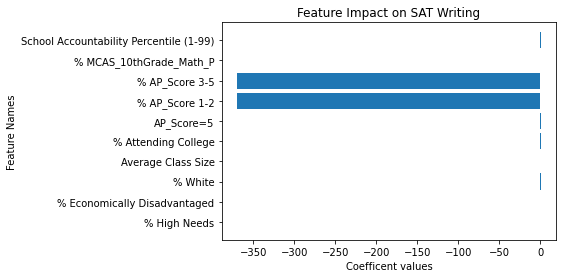

In [29]:
#Creating visual plots of the values of the coeffecients. The large the abosoulate the value the bigger the impact. Negative values decrease
# Negative values decrease SAT score overall, and vice versa for positive.
importance = regr.coef_[0]
plt.barh(FeatureNames, importance)
plt.title("Feature Impact on SAT Reading")
plt.xlabel("Coefficent values")
plt.ylabel("Feature Names")
plt.show()
importance = regr.coef_[1]
plt.barh(FeatureNames, importance)

plt.title("Feature Impact on SAT Math")
plt.xlabel("Coefficent values")
plt.ylabel("Feature Names")
plt.show()
importance = regr.coef_[2]
plt.barh(FeatureNames, importance)

plt.title("Feature Impact on SAT Writing")
plt.xlabel("Coefficent values")
plt.ylabel("Feature Names")
plt.show()

In [ ]:
 from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
r2 = r2_score(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)

print('The r2 is: ', r2)
print('The rmse is: ', rmse)

In [ ]:
r2 = r2_score(y_test['Average SAT_Writing'], predictions[:,0])
print("R-Square value for the writing test ",r2_score(y_test['Average SAT_Writing'], predictions[:,0]))
print("R-Square value for the math test ",r2_score(y_test['Average SAT_Math'], predictions[:,1]))
print("R-Square value for the reading test ",r2_score(y_test['Average SAT_Reading'], predictions[:,2]))

In [ ]:

print("R-Square value for the writing test ", mean_squared_error(y_test['Average SAT_Writing'], predictions[:,0],squared=False))
print("R-Square value for the math test ", mean_squared_error(y_test['Average SAT_Math'], predictions[:,1],squared=False))
print("R-Square value for the reading test ", mean_squared_error(y_test['Average SAT_Reading'], predictions[:,2],squared=False))

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators = 500, random_state = 0)
rfr.fit(XFinalTrain, y_train)
predictions2 = rfr.predict(XFinalTest)
r2_2 = r2_score(y_test, predictions2)
rmse_2 = mean_squared_error(y_test, predictions, squared=False)
print(r2_2,rmse_2)

rfr.feature_importances_

In [ ]:

rfr.feature_importances_[0]

In [ ]:
Y= df[["Average SAT_Writing",'Average SAT_Math','Average SAT_Reading']]

In [ ]:

rfrMath = RandomForestRegressor(n_estimators = 500, random_state = 0)
rfrMath.fit(XFinalTrain, y_train['Average SAT_Math'])
predictionsMath = rfrMath.predict(XFinalTest)
r2_Math = r2_score(y_test['Average SAT_Math'], predictionsMath)
rmse_Math = mean_squared_error(y_test['Average SAT_Math'], predictionsMath, squared=False)
print(r2_Math,rmse_Math)

importance = rfrMath.feature_importances_
plt.title("Feature Impact on SAT Math")
plt.xlabel("Coefficent values")
plt.ylabel("Feature Names")

plt.barh(FeatureNames, importance)
plt.show()

In [ ]:

rfrReading = RandomForestRegressor(n_estimators = 500, random_state = 0)
rfrReading.fit(XFinalTrain, y_train['Average SAT_Reading'])
predictionsReading = rfrReading.predict(XFinalTest)
r2_Reading = r2_score(y_test['Average SAT_Reading'], predictionsReading)
rmse_Reading = mean_squared_error(y_test['Average SAT_Reading'], predictionsReading, squared=False)
print(r2_Reading,rmse_Reading)

importance = rfrReading.feature_importances_
plt.title("Feature Impact on SAT Reading")
plt.xlabel("Coefficent values")
plt.ylabel("Feature Names")


plt.barh(FeatureNames, importance)
plt.show()

In [ ]:

rfrWriting = RandomForestRegressor(n_estimators = 500, random_state = 0)
rfrWriting.fit(XFinalTrain, y_train['Average SAT_Writing'])
predictionsWriting = rfrWriting.predict(XFinalTest)
r2_Writing = r2_score(y_test['Average SAT_Writing'], predictionsWriting)
rmse_Writing = mean_squared_error(y_test['Average SAT_Writing'], predictionsWriting, squared=False)
print(r2_Writing,rmse_Writing)


importance = rfrWriting.feature_importances_
plt.title("Feature Impact on SAT Writing")
plt.xlabel("Coefficent values")
plt.ylabel("Feature Names")

plt.barh(FeatureNames, importance)
plt.show()

<h1> Milestone 4 Overview </h1>
<p> The process for prepping the data was as follows </p>
<ul>
    <li>Input the data</li>
    <li>Observe overall trends</li>
    <li>Drop superfluous features</li>
    <li>Clean Na data </li>
    <li>Create Dummies Variables </li>
    <li> Use Recursive Feature Elimination to choose the most impactful features </li>
    </ul>
    
<p>The model created was a linear regression to start. This allowed us to measure the importance of the top features. The model has an r-sqaured value of 0.72 and rmse of 32.04 These are good baseline scores but clearly leave some room for improvement.</p>

<h2> Results </h2>
<p>I elected to try to focus on creating results that are very clearly readable and useable for a school that was working toward increasing a student's SAT score. This is why I used RFE to narrow down the feature list instead of PCA. PCA could very much have provided me with a super powerful and accurate model but I have concerns for how useable the data would have been to suggest an action plan for the institution. The list of most impactful features is as follows: </p>
<br>
</p>'% High Needs', '% Economically Disadvantaged', '% White',
       '% Attending College', '% MA State University', 'AP_Score=5',
       '% AP_Score 1-2', '% MCAS_10thGrade_Math_A', 'MCAS_10thGrade_Math_CPI',
       '% MCAS_10thGrade_English_A'
    
 </p>
 
 <p> I need to dig more but based on my expertise in the field these results give some actionable items for schools to consider. We can see that the largest negative impact on SAT performance is percentage of students with high needs. We can also see the percentage of white students plays a role in this too. These two note worthy results sadly show a much larger issue schools will be hard pressed to prevent. The most negative impact is having a high percentage of students with high needs. This means schools could focus more on helping students with these high needs but that is much easier said than done. There is also a clear racial issue that can help outline some systemic roadblocks with having a larger percentage of students who are white.A public school does not control these things. Going further into this though, the MCAS 10th grade tests correlate very closely with student success. This means supporting students on these accountability tests can also ensure these can be successful on the SAT.</p>
 
 <h2> Current Conclusions and Recommendations</h2>
 
 <p> This model is providing useful information but I would not recommend it for public production just yet. The model needs to be more rigorously examined for possible fitting issues. Furthermore, a second dataset with similar information but post pandemic could help clarify the importance of many features. In the current state this model should be part of a large action plan to support learning in schools and should be expanded upon to achieve the objective of the project. I am confident that with more tests to evaluate the project and comparisons to other models I can a strong recommendation for these schools. </p>


<h2> Milestone 2 and 3 </h2>

I have chosen to explore the relationship between educational data and two outcomes. One, how demographic information can predict students' performance on the SAT. Two, how student demographic information can predict college attendance. 

Purpose:

The purpose of this project is to take a deeper dive into how schools measure accountability and performance. Traditionally every state has a metric to suggest how well a school is performing. On a nationwide scale schools generally consider two factors across the board, college attendance, and performance on the Scholastic Aptitude Test(SAT).  This data set is rich with measures that could all play a bigger role in these outcomes that are not accounted for in these evaluation systems. I am going to approach the data trying to clearly define which features have impacts on these metrics and how impactul they are. At first glance we want to consider the following: location, funding, demographics, accountability measures. Working with this data, I hope to create a clear need for such models, and want to offer it as a proof of concept for my local district to collect such data. Ideally using it to support the needs of teachers and schools in our area.

Timeline:
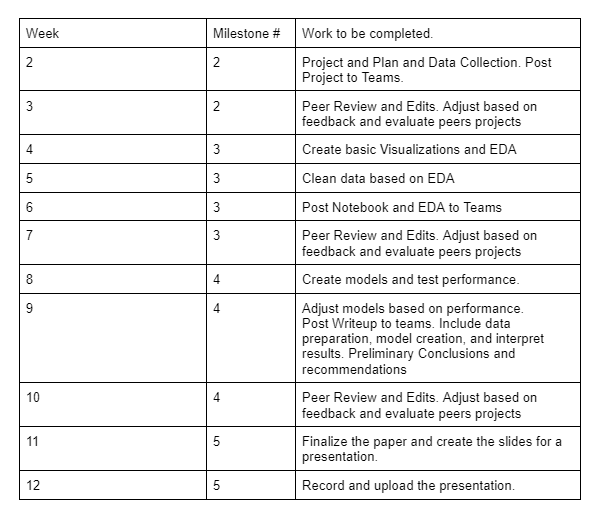
Data Selection:

After conferring with my local district and school they denied my initial request for de-identified student information. They brought up very valid concerns with possible violations of student personal data and FERPA protections. I moved onto a publicly available data source from Kaggel. MSC Public Schools shared a set of information that would suffice for my project exploration, so I went ahead and moved forward with this set. This data set will lay the groundwork for future study and impact of clearly impactful data points.



Data Cleaning:

There is a long road ahead of data cleaning for this project. Most schools are described by 303 features. I am going to be cutting demographic information that will not support the questions I seek to answer. For example, much of the information about the school location will be removed since the name of a school will have little impact on its performance. I will keep the zip codes linked to the schools and explore its impact on performance as these are effective generalized numbers for location. Also, I will be gleaning any schools that do not support up to 12th grade. The list has over 1800 schools and while this will remove many. A school that does not support up to 12th students will have their students' needs met by some local high school, and we can still well represent the student bodies. I will also take a moment to try and consolidate variables that clearly represent common values. For example, total expenditures, total students, and average expenditures per student should be able to be summarized by the last value in that list. Furthermore, the values are vastly different in some of their measurements, some are percentages, others are values in the millions. The remaining cleaned data will be scaled to help create make the training process more efficient computationally. 

Model Proposals :

Question 1: I will explore regression models to predict SAT value. Since this is a numerical prediction I feel regression models are the clear option. I will explore the impact of the following models using a pipeline and batch command to compare performance: Linear Regression, Ridge Regression..

After exploring the data I have narrowed my prospective model list to the following: Ridge and Linear regression. There are some multicollinearity concerns within the data and I want to see how using the Ridge regression can help support this for a prediction of student performance. I will explore correlation through the set of features to also address this. I kept a standard linear regression model to compare the results with. I dropped the LASSO regression as there are an abundance of features available for the data set and LASSO performs best when operating with a few critical features. In a similar light I dropped Bayesian Linear regression since the data is well distributed and abundant. 

Question 2: Using the data provided I am seeking to see what features play the largest role in if students from a school will attend college or university. These are presented in percentage values and will also be modeled using a linear or Ridge Regression.
Going forward this model does not lend itself to classification attempts as well as I originally imagined. I am going to use similar methods to address the percentages of students attending colleges based on cohort data as I do for success on the SAT. I will retain the use of a random forest to try and isolate the most important and impactful features to help support model creation though.

Visualization of Data:
I created a scatter plot of the geographical information to gain surface visualization of the information.  A correlation matrix will also be useful to help address multicollinearity concerns and get a better idea of features impacting the outcome. Lastly, I will have a plot of feature importance based on application of recursive feature elimination and a linear regression.

Evaluation of Results:

For both of the questions I will organize the information into a split test learn situation. I will begin with a simple accuracy measurement for each model to begin evaluation of how to select the correct model. Going further, for the regression models I will base performance on R-squared and RMSE to dig deeper into the aspects of model creation. I will be conducting performance tests using random forests to try to isolate the most important features as mentioned prior. Trying to limit the model to only the most impactful should improve efficiency with the data collected. This should also help us address issues with bias in the model if we perceive any. 

Expected Conclusions:

I expect to be able to understand what factors play a larger role in these values. I want to get a good idea of what predicts the performance of a student on the SAT and continuing their education. The goal is to be able to make recommendations to schools about where their efforts can be placed to help improve these outcomes. For example perhaps the structure of a school or how the money is spent can be better allocated.

Risk Assessment:

As mentioned in the data collection step there is a huge issue with data privacy in education. We are talking abou very real and raw data points about human beings. The data should only be shared in a way that ensures their identities cannot be divulged. That is why the data here is aggregated by school. This is a first step but I still need to ensure no privacy concerns will be raised. Furthermore, the impact of this information could have very real consequences. Just like creating a model to support business profits, creating a model to improve education performance will cause real change in a school. If this information is inaccurate it could have impacts on the lives of humans permanently. All recommendations should be backed by the absolute best practices to minimize harm.

Contingency Plan:

I have some concerns if the classification model will work the way I want it to. I am trying to summarize post secondary education from many options and it could be difficult to classify. If that fails I may have to evaluate the model choices. Furthermore if the data appears insufficient to make a conclusion at all I have a world wide dataset that could perhaps be applied to these concepts instead.
Revisiting this concept, the data is going to function very well for the questions being asked. With taking the time to narrow my approach with the models I still hold my original expectations and see less concern for this contingency plan.

Summary of Milestone 3:
Adjusted original questions and modeling approach to better match data, clearly defined the purpose of the project, discussed approach for data cleaning and data visualization. Incorporated feedback from peer review. 


In [ ]:
from platform import python_version 
python_version()